In [1]:
# Import necessary libraries
library(tidyverse)
library(readxl)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
taiwanese_data <- read_csv("taiwanese_data.csv", col_names = FALSE, skip = 1) |>
                  mutate(X1 = as_factor(X1))

Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(taiwanese_data)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3705943,0.4243894,0.4057498,0.6014572,0.6014572,0.9989692,0.7968871,0.8088094,0.3026464,⋯,0.7168453,0.009219440,0.6228790,0.6014533,0.8278902,0.2902019,0.02660063,0.5640501,1,0.01646874
1,0.4642909,0.5382141,0.5167300,0.6102351,0.6102351,0.9989460,0.7973802,0.8093007,0.3035564,⋯,0.7952971,0.008323302,0.6236517,0.6102365,0.8399693,0.2838460,0.26457682,0.5701749,1,0.02079431
1,0.4260713,0.4990188,0.4722951,0.6014500,0.6013635,0.9988574,0.7964034,0.8083875,0.3020352,⋯,0.7746697,0.040002853,0.6238410,0.6014493,0.8367743,0.2901885,0.02655472,0.5637061,1,0.01647411
1,0.3998440,0.4512647,0.4577333,0.5835411,0.5835411,0.9986997,0.7969670,0.8089656,0.3033495,⋯,0.7395545,0.003252475,0.6229287,0.5835376,0.8346971,0.2817212,0.02669663,0.5646634,1,0.02398233
1,0.4650222,0.5384322,0.5222978,0.5987835,0.5987835,0.9989731,0.7973661,0.8093037,0.3034750,⋯,0.7950159,0.003877563,0.6235207,0.5987815,0.8399727,0.2785138,0.02475185,0.5756166,1,0.03549020
1,0.3886803,0.4151766,0.4191338,0.5901714,0.5902507,0.9987581,0.7969032,0.8087706,0.3031158,⋯,0.7104205,0.005277875,0.6226046,0.5901723,0.8299390,0.2850871,0.02667537,0.5645383,1,0.01953448


In [4]:
taiwanese_data |> group_by(X1) |> summarize(n = n())

X1,n
<fct>,<int>
0,6599
1,220


In [5]:
set.seed(123)
taiwanese_bankrupt <- taiwanese_data |> filter(X1 == 1)
taiwanese_not_bankrupt <- taiwanese_data |> filter(X1 != 1)
taiwanese_not_bankrupt_small <- taiwanese_not_bankrupt |> sample_n(220)
taiwanese_small <- bind_rows(taiwanese_not_bankrupt_small, taiwanese_bankrupt)

In [6]:
taiwanese_small |> group_by(X1) |> summarize(n = n())

X1,n
<fct>,<int>
0,220
1,220


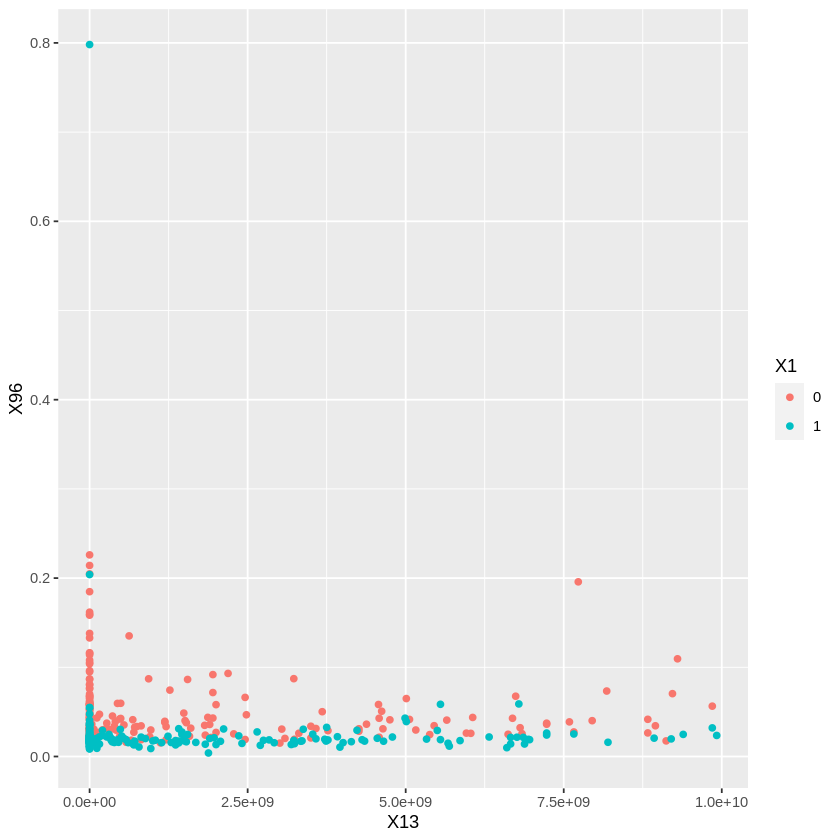

In [7]:
taiwanese_small |> ggplot(aes(x = X13, y = X96, color = X1)) + geom_point()

In [8]:
taiwanese_split <- initial_split(taiwanese_small, prop = 0.75, strata = X1)
taiwanese_training <- training(taiwanese_split)
taiwanese_testing <- testing(taiwanese_split)

In [9]:
k_vals <- tibble(neighbors = seq(from = 10, to = 40, by = 2))
taiwanese_folds <- taiwanese_training |> vfold_cv(v = 5, strata = X1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
taiwanese_recipe <- recipe(X1 ~ X13 + X96, data = taiwanese_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())
taiwanese_metrics <- workflow() |>
                     add_recipe(taiwanese_recipe) |>
                     add_model(knn_spec) |>
                     tune_grid(resamples = taiwanese_folds, grid = k_vals) |>
                     collect_metrics()

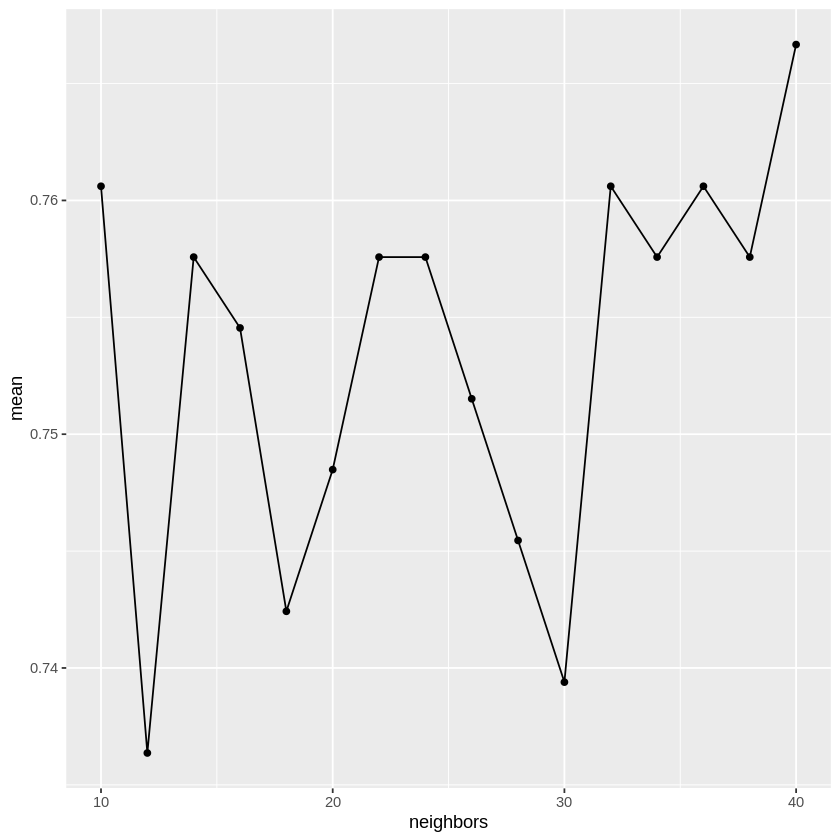

In [10]:
accuracies <- taiwanese_metrics |> filter(.metric == "accuracy")
accuracies |> ggplot(aes(x = neighbors, y = mean)) +
              geom_point() +
              geom_line()

In [11]:
best_k <- accuracies |> arrange(-mean) |> select(neighbors) |> slice(1) |> pull()
taiwanese_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                  set_engine("kknn") |>
                  set_mode("classification")
taiwanese_fit <- workflow() |>
                 add_recipe(taiwanese_recipe) |>
                 add_model(taiwanese_spec) |>
                 fit(taiwanese_training)

In [12]:
taiwanese_predictions <- taiwanese_fit |>
                         predict(taiwanese_testing) |>
                         select(.pred_class) |>
                         bind_cols(taiwanese_testing)
head(taiwanese_predictions)

.pred_class,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.5431190,0.5920737,0.5849350,0.6053345,0.6053345,0.9990763,0.7975313,0.8094156,⋯,0.8297697,0.0016849684,0.6240948,0.6053334,0.8418080,0.2755997,0.02680716,0.5652336,1,0.11563056
0,0,0.4584897,0.5204972,0.5093420,0.5979980,0.5978466,0.9989199,0.7973185,0.8092578,⋯,0.7860001,0.0012691150,0.6236744,0.5979932,0.8391495,0.2809730,0.02635868,0.5616676,1,0.02561750
0,0,0.4216838,0.4795028,0.4699395,0.6156618,0.6156618,0.9985364,0.7962086,0.8082043,⋯,0.7537003,0.0019382643,0.6238183,0.6156577,0.8379553,0.2751790,0.02678524,0.5651300,1,0.20473538
1,0,0.5497977,0.5988879,0.6042079,0.6112945,0.6112801,0.9991328,0.7975931,0.8094886,⋯,0.8306164,0.0044095471,0.6244503,0.6112955,0.8423934,0.2778483,0.02688546,0.5655712,1,0.04079785
0,0,0.4418174,0.4898604,0.4867498,0.6149483,0.6150564,0.9987508,0.7971252,0.8090627,⋯,0.7695722,0.0006425141,0.6241876,0.6149443,0.8387128,0.2753199,0.02678991,0.5651524,1,0.16180749
1,0,0.4327987,0.4989097,0.4857862,0.6001168,0.6001168,0.9989898,0.7973095,0.8092468,⋯,0.7788691,0.0005570835,0.6238940,0.6001170,0.8379208,0.2859532,0.02669017,0.5646260,1,0.01881964


In [13]:
taiwanese_predictions |> metrics(truth = X1, estimate = .pred_class)
taiwanese_predictions |> conf_mat(truth = X1, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8
kap,binary,0.6


          Truth
Prediction  0  1
         0 42  9
         1 13 46